In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import snscrape.modules.twitter as sntwitter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from datetime import date, timedelta
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import warnings
warnings.filterwarnings("ignore")

### Scrape Twitter stock prices

In [2]:
# Get dates between 2021-01-01 and 2022-10-27
start_date = date(2021, 1, 1) 
end_date = date(2022, 10, 27)    
delta = end_date - start_date

dates = []
for i in range(delta.days + 1):
    day = start_date + timedelta(days=i)
    dates.append(day)

df_dates = pd.DataFrame(dates)
df_dates.columns = ["Date_day"]
df_dates = df_dates["Date_day"].astype('str')

In [3]:
# Scrape Twitter stock prices
df_twitter_stock = yf.Ticker("TWTR")
df_twitter_stock = df_twitter_stock.history(period='max')
df_twitter_stock = df_twitter_stock.reset_index(level=0)
df_twitter_stock = df_twitter_stock[["Date", "Open", "High", "Low", "Close"]]

df_twitter_stock = (df_twitter_stock
  .assign(Open = df_twitter_stock.Open.fillna(0).astype('float16'))
  .assign(High = df_twitter_stock.High.fillna(0).astype('float16'))
  .assign(Low = df_twitter_stock.Low.fillna(0).astype('float16'))
  .assign(Close = df_twitter_stock.Close.fillna(0).astype('float16'))
)
df_twitter_stock["Date_day"] = df_twitter_stock["Date"].astype('str').str[:10]
df_twitter_stock = df_twitter_stock.drop_duplicates()
df_twitter_stock = pd.merge(df_dates, df_twitter_stock, how='left', left_on='Date_day', right_on='Date_day')

### Scrape Elon Musk Tweets

In [4]:
# Scrape Elon Musk Tweets
query = "(from:elonmusk) until:2022-10-27 since:2021-01-01"
tweets = []

def scrape_and_write_tweets(query: str, tweets: list) -> None:
    for tweet in sntwitter.TwitterSearchScraper(query).get_items():
        tweets.append([tweet.date, tweet.username, tweet.content, tweet.outlinks])

    df_tweets = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet', 'links'])
    df_tweets.to_parquet('df_tweets.parquet.gzip', compression='gzip')  

# scrape_and_write_tweets(query, tweets)

In [5]:
df_musk_tweets = pd.read_parquet('df_tweets.parquet.gzip')  
df_musk_twitter_tweets = df_musk_tweets.loc[df_musk_tweets["Tweet"].str.contains('Twitter')]
df_musk_twitter_tweets["Date_day"] = df_musk_twitter_tweets["Date"].astype('str').str[:10]
df_musk_twitter_activity = df_musk_twitter_tweets.groupby(['Date_day'])["Tweet"].count().reset_index().rename(columns={'Tweet':'Tweets'})
df_musk_twitter_activity = pd.merge(df_dates, df_musk_twitter_activity, how='left', left_on='Date_day', right_on='Date_day')

### Sentiment Analysis

In [6]:
# Sentiment Analysis
input_tweets = list(df_musk_twitter_tweets["Tweet"])
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline("sentiment-analysis", model = model, tokenizer=tokenizer)
results = classifier(input_tweets)

labels = []
scores = []
for result in results:
    labels.append(result["label"])
    scores.append(result["score"])

df_musk_twitter_tweets["sentiment_label"] = labels
df_musk_twitter_tweets["sentiment_score"] = scores 

# Positive Tweets
positive_tweets = df_musk_twitter_tweets.loc[df_musk_twitter_tweets["sentiment_label"] == "POSITIVE"][["Date", "Tweet", "Date_day", "sentiment_label", "sentiment_score"]]
positive_tweets_activity = positive_tweets.groupby(['Date_day'])["Tweet"].count().reset_index().rename(columns={'Tweet':'Tweets'})
positive_tweets_activity = pd.merge(df_dates, positive_tweets_activity, how='left', left_on='Date_day', right_on='Date_day')

# Negative Tweets
negative_tweets = df_musk_twitter_tweets.loc[df_musk_twitter_tweets["sentiment_label"] == "NEGATIVE"][["Date", "Tweet", "Date_day", "sentiment_label", "sentiment_score"]]
negative_tweets_activity = negative_tweets.groupby(['Date_day'])["Tweet"].count().reset_index().rename(columns={'Tweet':'Tweets'})
negative_tweets_activity = pd.merge(df_dates, negative_tweets_activity, how='left', left_on='Date_day', right_on='Date_day')
negative_tweets_activity["Tweets"] = negative_tweets_activity["Tweets"] * (-1)

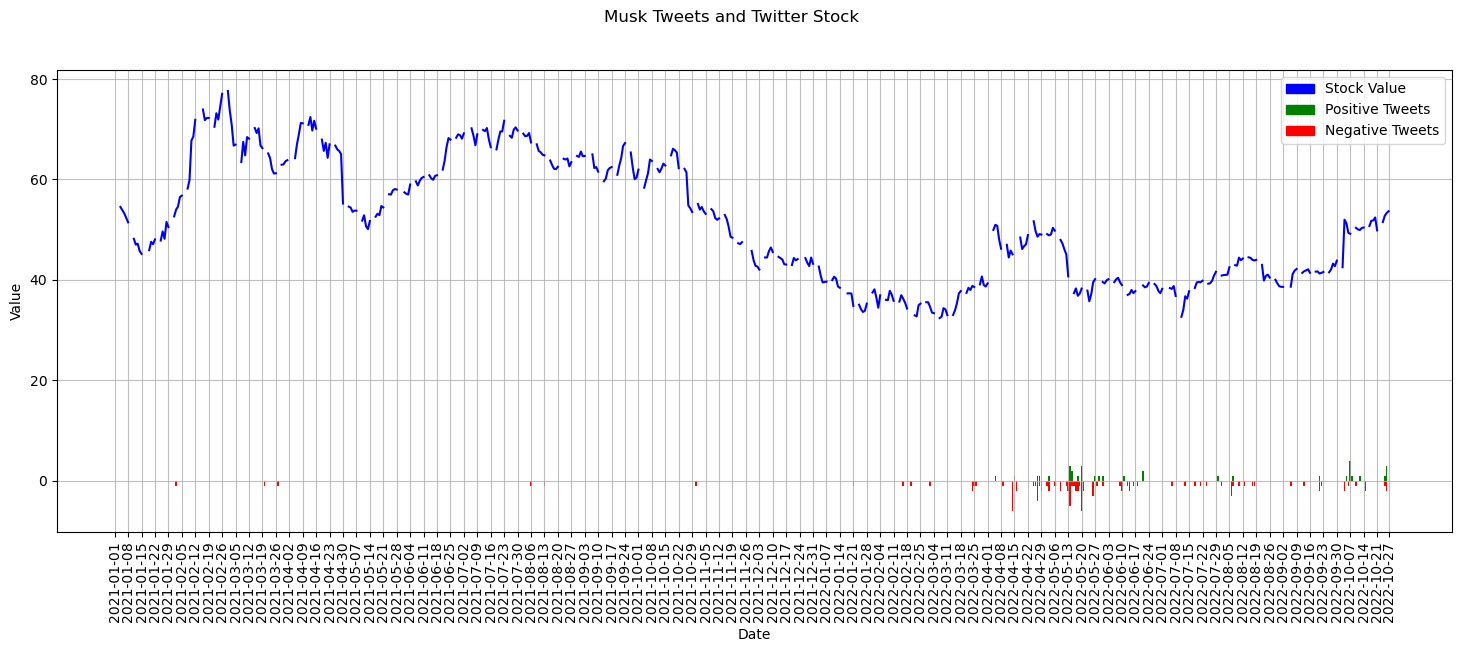

In [7]:
# Plot positive / negative tweets
fig, ax = plt.subplots(1, 1, figsize = (18, 6))
fig.suptitle("Musk Tweets and Twitter Stock")

plt.bar(positive_tweets_activity["Date_day"], positive_tweets_activity["Tweets"], color='green')
plt.bar(negative_tweets_activity["Date_day"], negative_tweets_activity["Tweets"], color='red')
plt.plot(df_twitter_stock["Date_day"], df_twitter_stock["Close"], color='blue')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.grid(alpha=0.8)
plt.xticks(list(df_twitter_stock.iloc[::7, :]["Date_day"]) 
              + list(df_twitter_stock.loc[df_twitter_stock["Date_day"] == df_twitter_stock["Date_day"].max()]["Date_day"]))

for label in ax.get_xticklabels():
  label.set_rotation(90)

green_patch = mpatches.Patch(color='green', label='Positive Tweets')
red_patch = mpatches.Patch(color='red', label='Negative Tweets')
blue_patch = mpatches.Patch(color='blue', label='Stock Value')
plt.legend(handles=[blue_patch, green_patch, red_patch])
plt.show()